# Compare background subtracted SSPALS traces (looped data)

<span style="color:red">IMPORTANT</span> - This notebook reads HDF5 files. Always PAUSE Sequencer.vi to run analysis for current sequence (HDF5 r/w conflict)!

In [1]:
#import python packages
import os
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline
import oskar, sspals

### Import

In [2]:
rid = '20160507_145210'
h5 = oskar.H5Data(rid)             # data
h5.load_log()
vDF = h5.var_df()
uDF = h5.unique_df()
out_dire = h5.out_dire("Traces")    # output
h5.pprint()

20160507_145210
   Author:	 AA
   Description:  n = 10 high res lineshape


In [3]:
uDF.head()

,DLY_EA,DLY_GA,IR,VOL_u100,VOL_u101
VID,,,,,
1,6.470000e-07,0.000001,756.20,2000,1600
2,6.470000e-07,0.000001,756.21,2000,1600
3,6.470000e-07,0.000001,757.50,2000,1600
4,6.470000e-07,0.000001,757.53,2000,1600
5,6.470000e-07,0.000001,757.56,2000,1600


In [4]:
#uDF[uDF.IR > 758.5]

## Import traditional SSPALS analysis

In [5]:
DF = oskar.average_data([rid], verbose=True, loop=True, fils=['avL_SSPALS_CH_L2[ -5.00e-09   4.80e-07   1.10e-06].dat'])
DF.head()

Loaded: avL_SSPALS_CH_L2[ -5.00e-09   4.80e-07   1.10e-06].dat


DLY_EA    DLY_GA      IR  VOL_u100  VOL_u101  \
RID             VID                                                       
20160507_145210 1    6.470000e-07  0.000001  756.20      2000      1600   
                2    6.470000e-07  0.000001  756.21      2000      1600   
                3    6.470000e-07  0.000001  757.50      2000      1600   
                4    6.470000e-07  0.000001  757.53      2000      1600   
                5    6.470000e-07  0.000001  757.56      2000      1600   

                     t0_ra_reps    t0_ra_mean     t0_ra_std     t0_ra_sem  \
RID             VID                                                         
20160507_145210 1         798.0  2.569564e-07  2.158906e-10  7.642446e-12   
                2         799.0  2.569830e-07  2.256272e-10  7.982118e-12   
                3         800.0  2.569333e-07  2.180167e-10  7.708053e-12   
                4         798.0  2.569431e-07  2.248399e-10  7.959247e-12   
                5         797.0  2.569369e-07  2.235092e-10  7.917100e-12   

                     DF_ra_reps  DF_ra_mean  DF_ra_std  DF_ra_sem  
RID             VID                                                
20160507_145210 1         798.0    0.018610   0.002078   0.000074  
                2         799.0    0.018767   0.002098   0.000074  
                3         800.0    0.018863   0.002129   0.000075  
                4         798.0    0.018777   0.002078   0.000074  
                5         797.0    0.018789   0.002152   0.000076

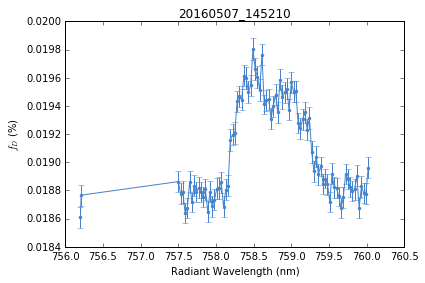

In [6]:
X = 'IR'
Y = 'DF_ra'
#plot setup
fig, ax = plt.subplots()
j = 0
sg = DF.loc[rid].sort_values(by=X)
x_vals = sg[X].values
y_vals = sg[Y+'_mean'].values
yerr = sg[Y+'_sem'].values
ax.errorbar(x_vals, y_vals, yerr=yerr, fmt ='.-', color=oskar.colors[j%7])

#format
ax.set_ylabel("$f_{D}$ (%)")
ax.set_xlabel("Radiant Wavelength (nm)")
#ax.set_xlim(x.min(), x.max())
ax.set_title(rid)
plt.tight_layout()

#save data
fileout = os.path.join(out_dire, "DF_linescan2.png")
plt.show()

### Define the background trace to which all others are compared

In [7]:
background_squids = vDF[vDF['IR'] < 758].index.values
background_squids

array([   2,    7,   14,   16,   17,   19,   22,   28,   33,   36,   52,
         56,   59,   62,   66,   67,   68,   70,   87,   89,   95,   97,
         98,  102,  103,  104,  107,  109,  110,  111,  119,  121,  125,
        129,  131,  132,  147,  162,  179,  183,  184,  187,  188,  191,
        201,  202,  209,  212,  218,  219,  228,  231,  234,  237,  240,
        242,  252,  262,  271,  290,  291,  297,  301,  305,  308,  309,
        313,  315,  318,  322,  326,  330,  331,  338,  340,  342,  350,
        361,  367,  368,  372,  373,  374,  376,  381,  382,  385,  399,
        400,  403,  416,  420,  421,  428,  433,  438,  441,  446,  447,
        448,  455,  463,  464,  466,  471,  473,  475,  479,  493,  498,
        507,  508,  517,  520,  532,  535,  538,  546,  548,  549,  552,
        553,  562,  565,  571,  585,  588,  592,  598,  600,  605,  607,
        608,  610,  613,  616,  617,  618,  622,  627,  632,  655,  659,
        663,  665,  668,  674,  675,  681,  684,  6

In [11]:
chan_hi = 'CH_L2'
chan_low = 'CH_L3'
hi, osc_hi = h5.load_array(background_squids, chan_hi)
low, osc_low = h5.load_array(background_squids, chan_low)
limits = [-1e-8, 1.7e-7, 6.5e-7]
dt = osc_hi['dt']
chmx_bk = sspals.chmx(hi, low, invert=True, n_bsub=100,
                   validate=True, min_range=0.1)
DF_bk = sspals.sspals(chmx_bk, dt, limits=limits)
x = (np.arange(np.shape(chmx_bk)[1])*dt) - DF_bk.t0.mean()

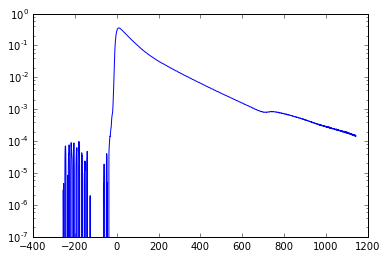

In [12]:
reps_bk = np.shape(chmx_bk)[0]
av_bk = np.mean(chmx_bk, axis=0)
error_bk = np.std(chmx_bk, axis=0) / np.sqrt(reps_bk)
plt.plot(x*1e9, av_bk)
plt.yscale('log')
plt.show()

### Find the background subtracted traces

In [13]:
# traces
diff = []
diff_error = []
for vid in tqdm(uDF.index):
    squids = vDF[(vDF == uDF.loc[vid]).all(1)].index.values
    hi, osc_hi = h5.load_array(squids, chan_hi)
    low, osc_low = h5.load_array(squids, chan_low)
    dt = osc_hi['dt']
    chmx = sspals.chmx(hi, low, invert=True, n_bsub=100,
                       validate=True, min_range=0.1)
    reps = np.shape(chmx)[0]
    average = np.mean(chmx, axis=0)
    error = np.std(chmx, axis=0)/ np.sqrt(reps)
    bksub = average/np.sum(average) - av_bk/np.sum(av_bk)
    diff.append(bksub)
    error_bksub = np.sqrt((error/np.sum(average))**2.0 + (error_bk/np.sum(av_bk))**2.0)
    diff_error.append(error_bksub)
diff = np.array(diff)
diff_error = np.array(diff_error)

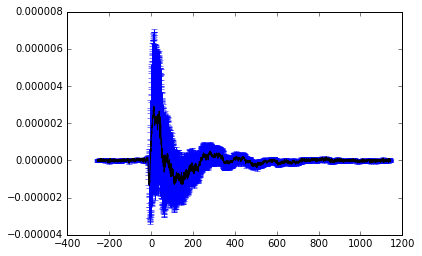

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.errorbar(x*1e9, diff[0], yerr=diff_error[0])
ax.plot(x*1e9, diff[0], ls='-', c='k')

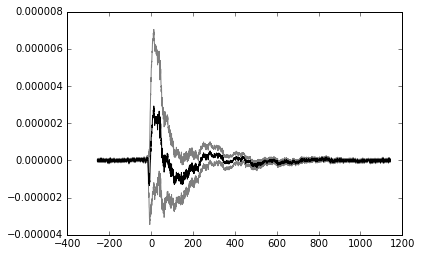

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
slice_ = 0
ax.plot(x*1e9, diff[slice_] + diff_error[slice_], ls='-', c='k', alpha=0.5)
ax.plot(x*1e9, diff[slice_], ls='-', c='k')
ax.plot(x*1e9, diff[slice_] - diff_error[slice_], ls='-', c='k', alpha=0.5)
plt.show()

### sum the absolute value of the background subtracted traces

In [16]:
diff_vals = np.sum(abs(diff), axis=1)
error_vals = np.sqrt(np.sum(diff_error**2.0, axis=1))

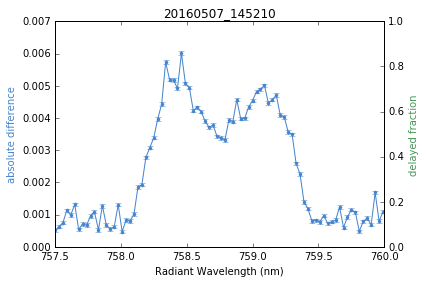

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.errorbar(x_vals, diff_vals, yerr=error_vals, fmt='.-', color=oskar.colors[0], label='abs')
ax.set_ylabel('absolute difference', color=oskar.colors[0])

ax2 = ax.twinx()
#ax2.errorbar(x_vals, y_vals, yerr=yerr, fmt ='.-', color=oskar.colors[1], label='trad.')
ax2.set_ylabel('delayed fraction', color=oskar.colors[1])

ax.set_xlabel("Radiant Wavelength (nm)")
ax.set_title(rid)
ax.set_xlim(757.5,760)

#save data
plt.tight_layout();
fileout = os.path.join(out_dire, "absolute.png")
plt.savefig(fileout, dpi=300)
plt.show()

### progressively introduce a mask to the summing region

In [19]:
threeD_vals = []
for i in trange(len(diff[0])):
    d_vals = np.sum(abs(diff[:, i:]), axis=1)
    threeD_vals.append(d_vals)
threeD_vals = np.array(threeD_vals)

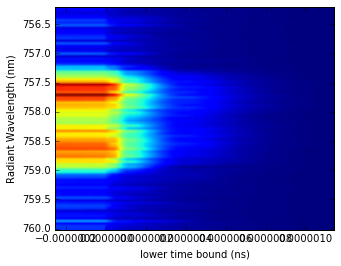

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(threeD_vals.T, aspect='auto', extent=[x.min(),x.max(),x_vals.max(),x_vals.min()]) # assumes linear xscale
ax.set_xlabel("lower time bound (ns)")
ax.set_ylabel("Radiant Wavelength (nm)")
plt.show()

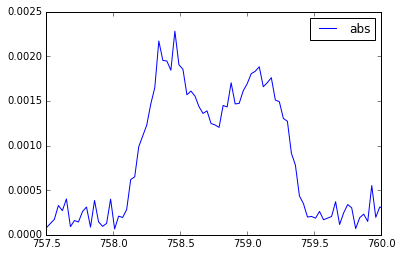

In [27]:
plt.plot(x_vals, 0.4*(threeD_vals[100] - np.mean(threeD_vals[1000][0:5])), label='abs')
#plt.plot(x_vals, (y_vals - np.mean(y_vals[0:5])), label='trad.')
plt.legend()
plt.xlim(757.5,760)
plt.show()